<a href="https://colab.research.google.com/github/giastoica/product-category-prediction/blob/main/notebooks/product_category_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Project name**: Product category prediction

*Author*: Giorgiana Stoica

Machine learning project for predicting the product category based on product titles. Includes data cleaning, feature extraction, model training, and evaluation using real-world e-commerce product data

1. Initial Data Loading and Exploratory Analysis (EDA)

The first step is to load the dataset and perform a preliminary analysis to understand its structure, size, and data types. This cell combines data loading, shape and head display, and a check for missing values.

Dataset shape (rows, columns): (35311, 8)

First 5 rows:


,product ID,Product Title,Merchant ID,Category Label,_Product Code,Number_of_Views,Merchant Rating,Listing Date
0,1,apple iphone 8 plus 64gb silver,1,Mobile Phones,QA-2276-XC,860.0,2.5,5/10/2024
1,2,apple iphone 8 plus 64 gb spacegrau,2,Mobile Phones,KA-2501-QO,3772.0,4.8,12/31/2024
2,3,apple mq8n2b/a iphone 8 plus 64gb 5.5 12mp sim...,3,Mobile Phones,FP-8086-IE,3092.0,3.9,11/10/2024
3,4,apple iphone 8 plus 64gb space grey,4,Mobile Phones,YI-0086-US,466.0,3.4,5/2/2022
4,5,apple iphone 8 plus gold 5.5 64gb 4g unlocked ...,5,Mobile Phones,NZ-3586-WP,4426.0,1.6,4/12/2023



Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35311 entries, 0 to 35310
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   product ID       35311 non-null  int64  
 1   Product Title    35139 non-null  object 
 2   Merchant ID      35311 non-null  int64  
 3   Category Label   35267 non-null  object 
 4   _Product Code    35216 non-null  object 
 5   Number_of_Views  35297 non-null  float64
 6   Merchant Rating  35141 non-null  float64
 7   Listing Date     35252 non-null  object 
dtypes: float64(2), int64(2), object(4)
memory usage: 2.2+ MB

Missing values per column:
product ID           0
Product Title      172
Merchant ID          0
Category Label      44
_Product Code       95
Number_of_Views     14
Merchant Rating    170
Listing Date        59
dtype: int64


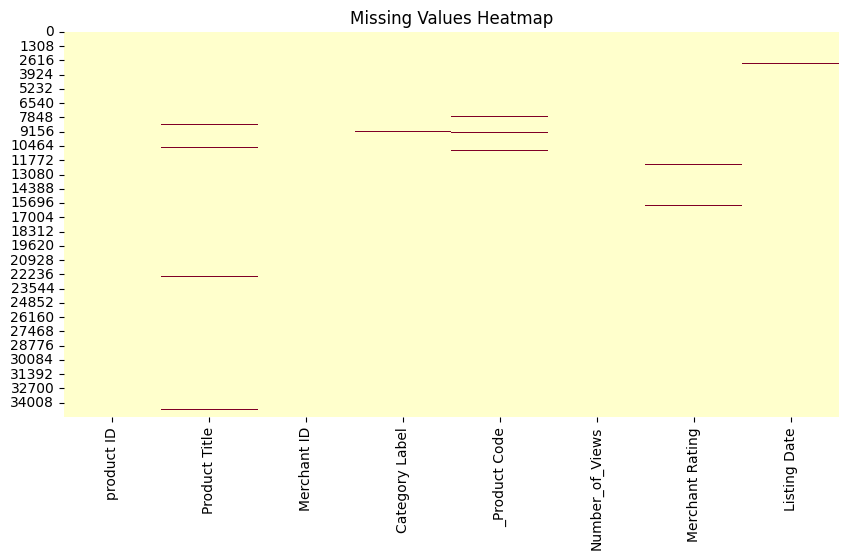

In [11]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load dataset from GitHub
url = "https://raw.githubusercontent.com/giastoica/product-category-prediction/main/data/products.csv"
try:
    df = pd.read_csv(url)
except Exception as e:
    print(f"Error loading data from URL: {e}")

# Fix column names by stripping whitespace
df.columns = df.columns.str.strip()

print("Dataset shape (rows, columns):", df.shape)
print("\nFirst 5 rows:")
display(df.head())

print("\nDataset info:")
df.info()

# Count and visualize missing values
print("\nMissing values per column:")
print(df.isna().sum())

plt.figure(figsize=(10, 5))
sns.heatmap(df.isna(), cbar=False, cmap="YlOrRd")
plt.title("Missing Values Heatmap")
plt.show()

In [ ]:
# Count missing values per column
print("Missing values per column:")
print(df.isna().sum())

Missing values per column:
product ID           0
Product Title      172
Merchant ID          0
 Category Label     44
_Product Code       95
Number_of_Views     14
Merchant Rating    170
 Listing Date       59
dtype: int64


Here’s what it tells us:

Product ID → ✅ No missing values (good, can act as unique key).

Product Title (172 missing) → ❌ Problematic, since titles are the basis for category prediction. These rows may need dropping (or flagging separately).

Merchant ID (0 missing) → ✅ Clean.

Category Label (44 missing) → ❌ These are the target labels. Rows without categories can’t be used for training but might be useful for prediction after training.

_Product Code (95 missing) → ⚠ Could be imputed/dropped, depending on whether you use it as a feature.

Number_of_Views (14 missing) → ⚠ Small number missing → imputation (mean/median) or drop.

Merchant Rating (170 missing) → ⚠ Could impute (median) or drop — depends on importance.

Listing Date (59 missing) → ⚠ Convert to datetime and decide: missing dates can be filled with a placeholder or dropped.

👉 Suggested handling strategy:

Drop rows with missing Product Title (since text is essential).

Exclude rows with missing Category Label when training the model, but you can later predict their categories.

Impute numeric fields (Number_of_Views, Merchant Rating) with median values.

Keep _Product Code and Listing Date only if they’re relevant for prediction (otherwise drop them to simplify).


2. Comprehensive Data Cleaning and Separation

This is a single, unified cell for all data cleaning tasks, eliminating the repetition from the original code. It applies the suggested strategy: dropping rows with missing titles, separating data for training and future prediction, and imputing missing numeric values.

In [15]:
# Drop rows with missing Product Title, as it is the core feature
df_clean = df.dropna(subset=["Product Title"]).copy()

# Separate data into a training set (with Category Label) and an unlabeled set (to be predicted later)
df_train = df_clean[df_clean["Category Label"].notna()].copy()
df_unlabeled = df_clean[df_clean["Category Label"].isna()].copy()

# Impute numeric fields with the median value from the training data
for col in ["Number_of_Views", "Merchant Rating"]:
    median_value = df_train[col].median()
    df_train.loc[:, col] = df_train[col].fillna(median_value)
    df_unlabeled.loc[:, col] = df_unlabeled[col].fillna(median_value)

# Convert Listing Date to datetime objects, specifying the format and coercing errors
df_train.loc[:, "Listing Date"] = pd.to_datetime(df_train["Listing Date"], format="%m/%d/%Y", errors="coerce")
df_unlabeled.loc[:, "Listing Date"] = pd.to_datetime(df_unlabeled["Listing Date"], format="%m/%d/%Y", errors="coerce")

# Reset the index for both DataFrames
df_train.reset_index(drop=True, inplace=True)
df_unlabeled.reset_index(drop=True, inplace=True)

# Display the info of the cleaned and separated datasets
print(df_train.info())
print(df_unlabeled.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35096 entries, 0 to 35095
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   product ID       35096 non-null  int64  
 1   Product Title    35096 non-null  object 
 2   Merchant ID      35096 non-null  int64  
 3   Category Label   35096 non-null  object 
 4   _Product Code    35002 non-null  object 
 5   Number_of_Views  35096 non-null  float64
 6   Merchant Rating  35096 non-null  float64
 7   Listing Date     35038 non-null  object 
dtypes: float64(2), int64(2), object(4)
memory usage: 2.1+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43 entries, 0 to 42
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   product ID       43 non-null     int64  
 1   Product Title    43 non-null     object 
 2   Merchant ID      43 non-null     int64  
 3   Category Label   0 non-null 

3. Feature Engineering
This cell defines and applies the feature engineering logic. The new features derived from Product Title and Listing Date are created here to enrich both the training and unlabeled data.

In [16]:
import re

# Define a list of common brands (this can be expanded)
brands = ['Acer', 'Apple', 'Dell', 'HP', 'Lenovo', 'Samsung', 'Sony', 'LG', 'Microsoft', 'Nikon']

# Function to check for special characters
def has_special_chars(text):
    return 1 if re.search(r'[!@#$%^&*()_+={}\[\]:;"\'<,>/?\\|`~]', text) else 0

# Function to check for all caps words (ignoring short words)
def has_all_caps_word(text):
    return 1 if any(word.isupper() and len(word) > 1 for word in text.split()) else 0

def feature_engineer(df):
    """
    Applies feature engineering to a DataFrame.
    """
    df_copy = df.copy()

    # Create new features from Product Title
    df_copy['Title Word Count'] = df_copy['Product Title'].apply(lambda x: len(x.split()))
    df_copy['Title Char Count'] = df_copy['Product Title'].apply(lambda x: len(x))
    df_copy['Has Numbers'] = df_copy['Product Title'].apply(lambda x: 1 if any(char.isdigit() for char in x) else 0)
    df_copy['Has Special Chars'] = df_copy['Product Title'].apply(has_special_chars)
    df_copy['Has All Caps Word'] = df_copy['Product Title'].apply(has_all_caps_word)
    df_copy['Longest Word Length'] = df_copy['Product Title'].apply(lambda x: max(len(word) for word in x.split()) if x.split() else 0)
    df_copy['Is Brand Mentioned'] = df_copy['Product Title'].apply(lambda x: 1 if any(brand.lower() in x.lower() for brand in brands) else 0)

    # Convert Listing Date to numerical features (e.g., month, day of week)
    # Ensure Listing Date is in datetime format before extracting features
    df_copy['Listing Date'] = pd.to_datetime(df_copy['Listing Date'], errors='coerce') # Ensure datetime format, coerce errors to NaT
    df_copy['Listing Month'] = df_copy['Listing Date'].dt.month
    df_copy['Listing Day of Week'] = df_copy['Listing Date'].dt.dayofweek
    df_copy = df_copy.drop(columns=['Listing Date'])

    return df_copy

# Apply feature engineering to both training and unlabeled data
df_train_enriched = feature_engineer(df_train)
df_unlabeled_enriched = feature_engineer(df_unlabeled)

# Display the new features
print("Enriched training data with new features:")
display(df_train_enriched.head())

print("\nEnriched unlabeled data with new features:")
display(df_unlabeled_enriched.head())

Enriched training data with new features:


,product ID,Product Title,Merchant ID,Category Label,_Product Code,Number_of_Views,Merchant Rating,Title Word Count,Title Char Count,Has Numbers,Has Special Chars,Has All Caps Word,Longest Word Length,Is Brand Mentioned,Listing Month,Listing Day of Week
0,1,apple iphone 8 plus 64gb silver,1,Mobile Phones,QA-2276-XC,860.0,2.5,6,31,1,0,0,6,1,5.0,4.0
1,2,apple iphone 8 plus 64 gb spacegrau,2,Mobile Phones,KA-2501-QO,3772.0,4.8,7,35,1,0,0,9,1,12.0,1.0
2,3,apple mq8n2b/a iphone 8 plus 64gb 5.5 12mp sim...,3,Mobile Phones,FP-8086-IE,3092.0,3.9,13,70,1,1,0,10,1,11.0,6.0
3,4,apple iphone 8 plus 64gb space grey,4,Mobile Phones,YI-0086-US,466.0,3.4,7,35,1,0,0,6,1,5.0,0.0
4,5,apple iphone 8 plus gold 5.5 64gb 4g unlocked ...,5,Mobile Phones,NZ-3586-WP,4426.0,1.6,11,54,1,0,0,8,1,4.0,2.0



Enriched unlabeled data with new features:


,product ID,Product Title,Merchant ID,Category Label,_Product Code,Number_of_Views,Merchant Rating,Title Word Count,Title Char Count,Has Numbers,Has Special Chars,Has All Caps Word,Longest Word Length,Is Brand Mentioned,Listing Month,Listing Day of Week
0,163,apple iphone 7 4.7 single sim 4g 2gb 128gb 196...,11,NaN,YI-3786-VT,2999.0,3.5,11,55,1,0,0,7,1,9,6
1,763,cat s60 11.9 cm 4.7 1280 x 720 pixels flat 16 ...,18,NaN,EH-9590-FN,1531.0,2.0,15,60,1,0,0,6,0,8,2
2,1673,microsoft lumia 650 lte black,2,NaN,DD-7007-CR,4850.0,2.5,5,29,1,0,0,9,1,2,3
3,2660,motorola moto x style,48,NaN,HS-2790-NX,3830.0,2.5,4,21,0,0,0,8,0,2,6
4,2822,doro phoneeasy 615 black,69,NaN,MA-0843-ME,1812.0,3.3,4,24,1,0,0,9,0,10,2
